In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

you can use ℓ2 regularization to constrain a neural network’s connection weights, and/or ℓ1 regularization if you want a sparse model

In [3]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

The l2() function returns a regularizer that will be called at each step during training to compute the regularization loss. This is then added to the final loss. As you might expect, you can just use keras.regularizers.l1() if you want ℓ1 regularization; if you want both ℓ1 and ℓ2 regularization, use keras.regularizers.l1_l2()

Since you will typically want to apply the same regularizer to all layers in your network, as well as using the same activation function and the same initialization strategy in all hidden layers, you may find yourself repeating the same arguments. This makes the code ugly and error-prone. To avoid this, you can try refactoring your code to use loops. Another option is to use Python’s functools.partial() function, which lets you create a thin wrapper for any callable, with some default argument values:


#### note - also added some dropout layers here and batch normalizaiton

In [4]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    RegularizedDense(300),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.2),
    RegularizedDense(100),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.2),
    RegularizedDense(1,
                     kernel_initializer="glorot_uniform")
])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               2700      
_________________________________________________________________
batch_normalization (BatchNo (None, 300)               1200      
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0

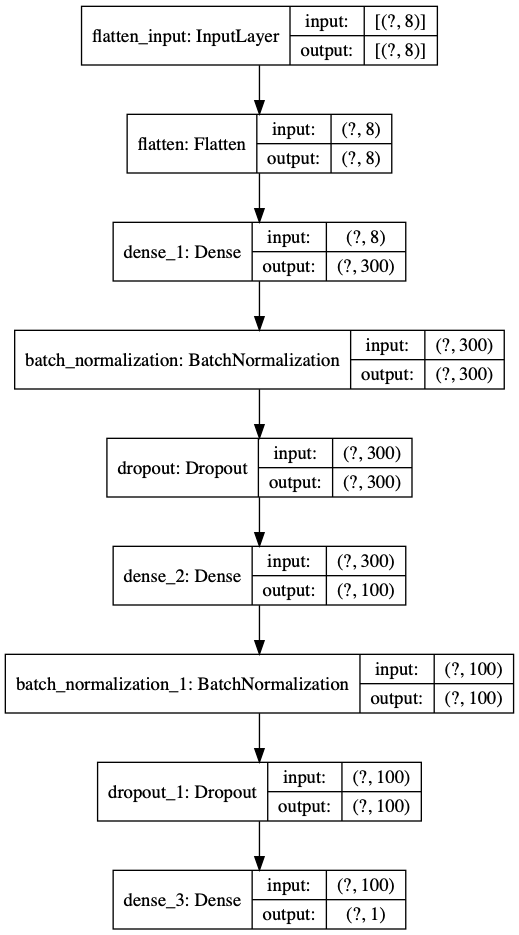

In [6]:
keras.utils.plot_model(model, "diagrams/08_test.png", show_shapes=True)

### also add checkpoint here 

In [37]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("keras_models/06_callback.h5", save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)
      

model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=100, 
                    validation_data=(X_valid, y_valid),
                   callbacks = [checkpoint_cb, early_stopping_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 65us/sample - loss: 5.9119 - val_loss: 5.7991
Epoch 2/100
11610/11610 [==============================] - 0s 42us/sample - loss: 5.8268 - val_loss: 5.7362
Epoch 3/100
11610/11610 [==============================] - 0s 38us/sample - loss: 5.7474 - val_loss: 5.6617
Epoch 4/100
11610/11610 [==============================] - 0s 38us/sample - loss: 5.6636 - val_loss: 5.6152
Epoch 5/100
11610/11610 [==============================] - 0s 38us/sample - loss: 5.5889 - val_loss: 5.6545
Epoch 6/100
11610/11610 [==============================] - 0s 40us/sample - loss: 5.5153 - val_loss: 5.4911
Epoch 7/100
11610/11610 [==============================] - 0s 39us/sample - loss: 5.4435 - val_loss: 5.5030
Epoch 8/100
11610/11610 [==============================] - 0s 40us/sample - loss: 5.3636 - val_loss: 5.3549
Epoch 9/100
11610/11610 [==============================] - 0s 39us/sample - loss: 5.291

Epoch 76/100
11610/11610 [==============================] - 0s 36us/sample - loss: 2.2848 - val_loss: 2.2391
Epoch 77/100
11610/11610 [==============================] - 0s 37us/sample - loss: 2.2571 - val_loss: 2.2144
Epoch 78/100
11610/11610 [==============================] - 0s 37us/sample - loss: 2.2328 - val_loss: 2.1872
Epoch 79/100
11610/11610 [==============================] - 0s 37us/sample - loss: 2.2062 - val_loss: 2.1630
Epoch 80/100
11610/11610 [==============================] - 0s 37us/sample - loss: 2.1801 - val_loss: 2.1420
Epoch 81/100
11610/11610 [==============================] - 0s 38us/sample - loss: 2.1597 - val_loss: 2.1207
Epoch 82/100
11610/11610 [==============================] - 0s 38us/sample - loss: 2.1280 - val_loss: 2.0935
Epoch 83/100
11610/11610 [==============================] - 1s 44us/sample - loss: 2.1067 - val_loss: 2.0697
Epoch 84/100
11610/11610 [==============================] - 0s 39us/sample - loss: 2.0874 - val_loss: 2.0447
Epoch 85/100
11610/

In [35]:
model = keras.models.load_model("keras_models/06_callback.h5") # rollback to best model

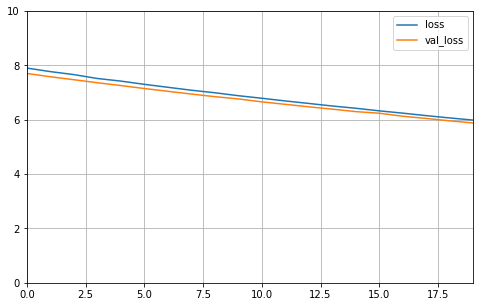

In [36]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 10) # set the vertical range to [0-1]
plt.show()